<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/Find_Disorder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find_Disorder.ipynb
---


>
Calculates the structural disorder in a spherical nanoparticle as a function of the radial distance from the center. This requires a perfectly unrelaxed lattice to compare to the relaxed/disordered lattice.

---

## Import Packages

In [1]:
import csv
import numpy as np
from astropy.coordinates import cartesian_to_spherical
import pandas as pd
import scipy as sp
from scipy import optimize
from google.colab import files
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Helper Functions and Gloabl Variables

In [2]:
def cartesian_to_spherical(x,y,z,lp):
    #takes x,y,z coords and lattice parameter
    x = x*lp
    y = y*lp
    z = z*lp
    r       =  np.sqrt((x*x + y*y + z*z))
    theta   =  np.arccos(z/r)*180/np.pi #to degrees
    phi     =  np.sign(y)*np.arccos(x/np.sqrt(x*x +y*y))*180/np.pi
    return [r,theta,phi]

## Extract Data and Name Variables

In [25]:
file_unrelaxed = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Control/STRs/Coreshell5050_AuNi_onAu_voidless.stru"
file_relaxed = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_AuNi_onAu_r25_2000Cycles/2000_voidless.stru"
lattice_parameter = 4.0789
plotTitle = r'Structural Disorder: MMC_AuNi_r25A'
plotsavename1 = r'Stru_Dis_MMC_AuNi_r25A.png'
plotsavename2 = r'Error_Bars_MMC_AuNi_r25.png'
plotsavename3 = r'STD_vs_Radius_MMC_AuNi_r25.png'
plotsavename4 = r'deltaTheta_vs_deltaR_MMC_AuNi_r25.png'
#csvsavename = r'RMC_PtAu_CP.csv'

In [4]:
################################################################################
# Extract and Format data from "file_unrelaxed"
################################################################################
data1 = pd.read_csv(file_unrelaxed, skiprows=3)
data1 = data1.drop(data1.columns[3:], axis=1)
data1[["atoms", "x"]] = data1[data1.columns[0]].str.split(expand=True)
data1 = data1.drop(data1.columns[0], axis=1)
data1 = data1.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data1["x"] = data1["x"].astype(float)
data1["y"] = data1["y"].astype(float)
data1["z"] = data1["z"].astype(float)
data1["distance"], data1["theta"], data1["phi"] = cartesian_to_spherical(data1["x"], data1["y"], data1["z"],lattice_parameter)
data1 = data1.rename(columns={"x":"x_base", "y":"y_base", "z":"z_base", "distance":"distance_base", "theta":"theta_base", "phi":"phi_base"})
data1 = data1[["atom","x_base", "y_base", "z_base", "distance_base", "theta_base", "phi_base"]]

In [5]:
################################################################################
# Extract and Format data from "file_relaxed"
################################################################################
data2 = pd.read_csv(file_relaxed, skiprows=3)
data2 = data2.drop(data2.columns[3:], axis=1)
data2[["atoms", "x"]] = data2[data2.columns[0]].str.split(expand=True)
data2 = data2.drop(data2.columns[0], axis=1)
data2 = data2.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data2["x"] = data2["x"].astype(float)
data2["y"] = data2["y"].astype(float)
data2["z"] = data2["z"].astype(float)
data2["distance"], data2["theta"], data2["phi"] = cartesian_to_spherical(data2["x"], data2["y"], data2["z"],lattice_parameter)
data2 = data2.rename(columns={"x":"x_adj", "y":"y_adj", "z":"z_adj", "distance":"distance_adj", "theta":"theta_adj", "phi":"phi_adj"})
data2 = data2[["atom","x_adj", "y_adj", "z_adj", "distance_adj", "theta_adj", "phi_adj"]]

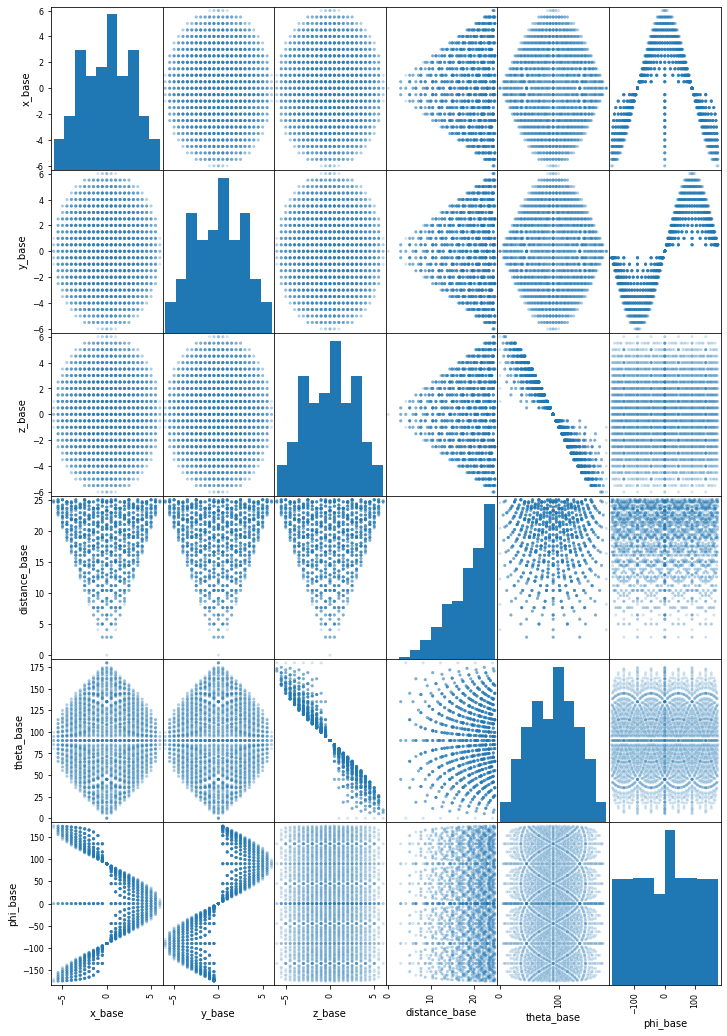

In [22]:
pd.plotting.scatter_matrix(data1, alpha=.2, figsize=(12,18));

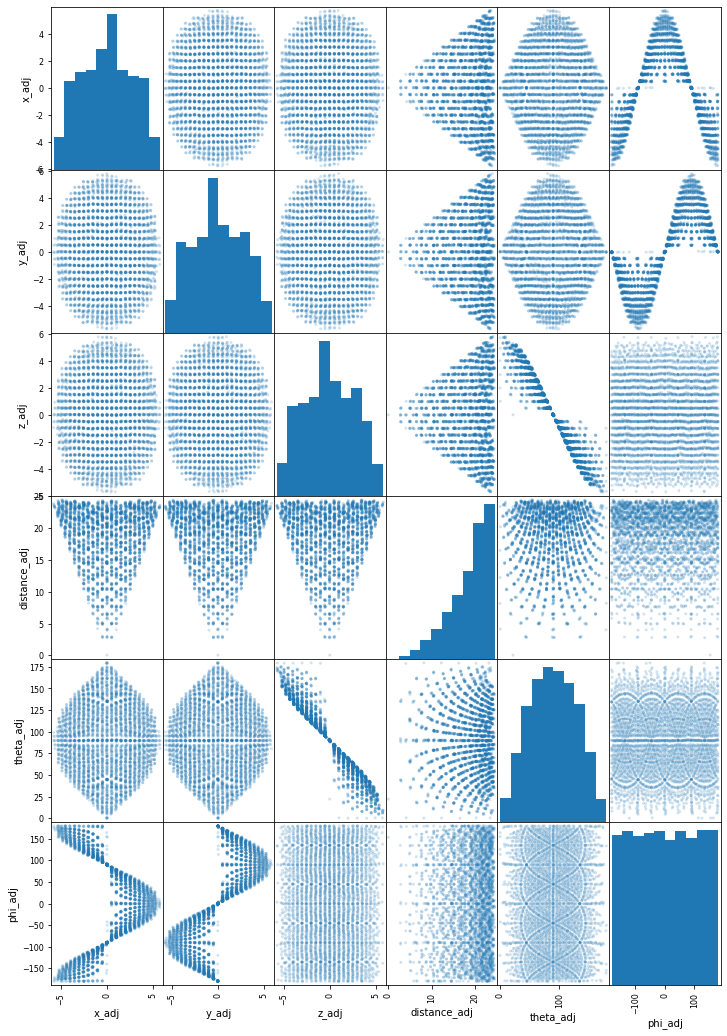

In [24]:
pd.plotting.scatter_matrix(data2, alpha=.2, figsize=(12,18));

In [8]:
################################################################################
# Combine formatted data from "file_unrelaxed" and "file_relaxed" and calculate
# the difference in each atoms' spherical coordinates 
################################################################################
data_total = pd.concat([data1, data2], axis=1)
data_total["delta_r"] = data_total["distance_adj"] - data_total["distance_base"]
data_total["delta_theta"] = data_total["theta_adj"] - data_total["theta_base"]
data_total["delta_phi"] = data_total["phi_adj"] - data_total["phi_base"]

In [9]:
data_total

atom  x_base  y_base  z_base  distance_base  theta_base    phi_base atom  \
0      NI    -1.0    -2.5    -5.5      24.978059  153.915458 -111.801409   NI   
1      NI     0.0    -2.5    -5.5      24.642768  155.556045  -90.000000   NI   
2      NI     1.0    -2.5    -5.5      24.978059  153.915458  -68.198591   NI   
3      NI    -2.0    -1.5    -5.5      24.642768  155.556045 -143.130102   NI   
4      NI    -1.5    -2.0    -5.5      24.642768  155.556045 -126.869898   NI   
...   ...     ...     ...     ...            ...         ...         ...  ...   
3920   NI    -0.5     0.5     6.0      24.642768    6.721369  135.000000   NI   
3921   NI     0.0     0.0     6.0      24.473400    0.000000         NaN   NI   
3922   NI     0.5     0.5     6.0      24.642768    6.721369   45.000000   NI   
3923   NI     1.0     0.0     6.0      24.810980    9.462322    0.000000   NI   
3924   NI     0.0     1.0     6.0      24.810980    9.462322   90.000000   NI   

         x_adj     y_adj     z_adj  distance_adj   theta_adj     phi_adj  \
0    -1.022507 -2.558300 -5.186067     23.953151  152.020754 -111.785711   
1     0.011494 -2.567749 -5.216707     23.716444  153.792603  -89.743529   
2     0.975354 -2.550833 -5.176299     23.871894  152.184474  -69.074803   
3    -2.128689 -1.462231 -5.227954     23.784198  153.711369 -145.514196   
4    -1.542907 -2.051780 -5.142425     23.443883  153.470990 -126.942603   
...        ...       ...       ...           ...         ...         ...   
3920 -0.540280  0.486986  5.768972     23.717355    7.186049  137.969811   
3921 -0.052076  0.014448  5.739649     23.412492    0.539467  164.493822   
3922  0.454147  0.446335  5.755478     23.619258    6.313279   44.502951   
3923  0.926530  0.060316  5.698380     23.549645    9.254418    3.724631   
3924 -0.037519  0.917126  5.824988     24.052721    8.954950   92.342625   

       delta_r  delta_theta  delta_phi  
0    -1.024909    -1.894704   0.015698  
1    -0.926324    -1.763443   0.256471  
2    -1.106165    -1.730984  -0.876212  
3    -0.858570    -1.844676  -2.384094  
4    -1.198885    -2.085055  -0.072705  
...        ...          ...        ...  
3920 -0.925413     0.464680   2.969811  
3921 -1.060908     0.539467        NaN  
3922 -1.023510    -0.408090  -0.497049  
3923 -1.261335    -0.207904   3.724631  
3924 -0.758259    -0.507372   2.342625  

[3925 rows x 17 columns]

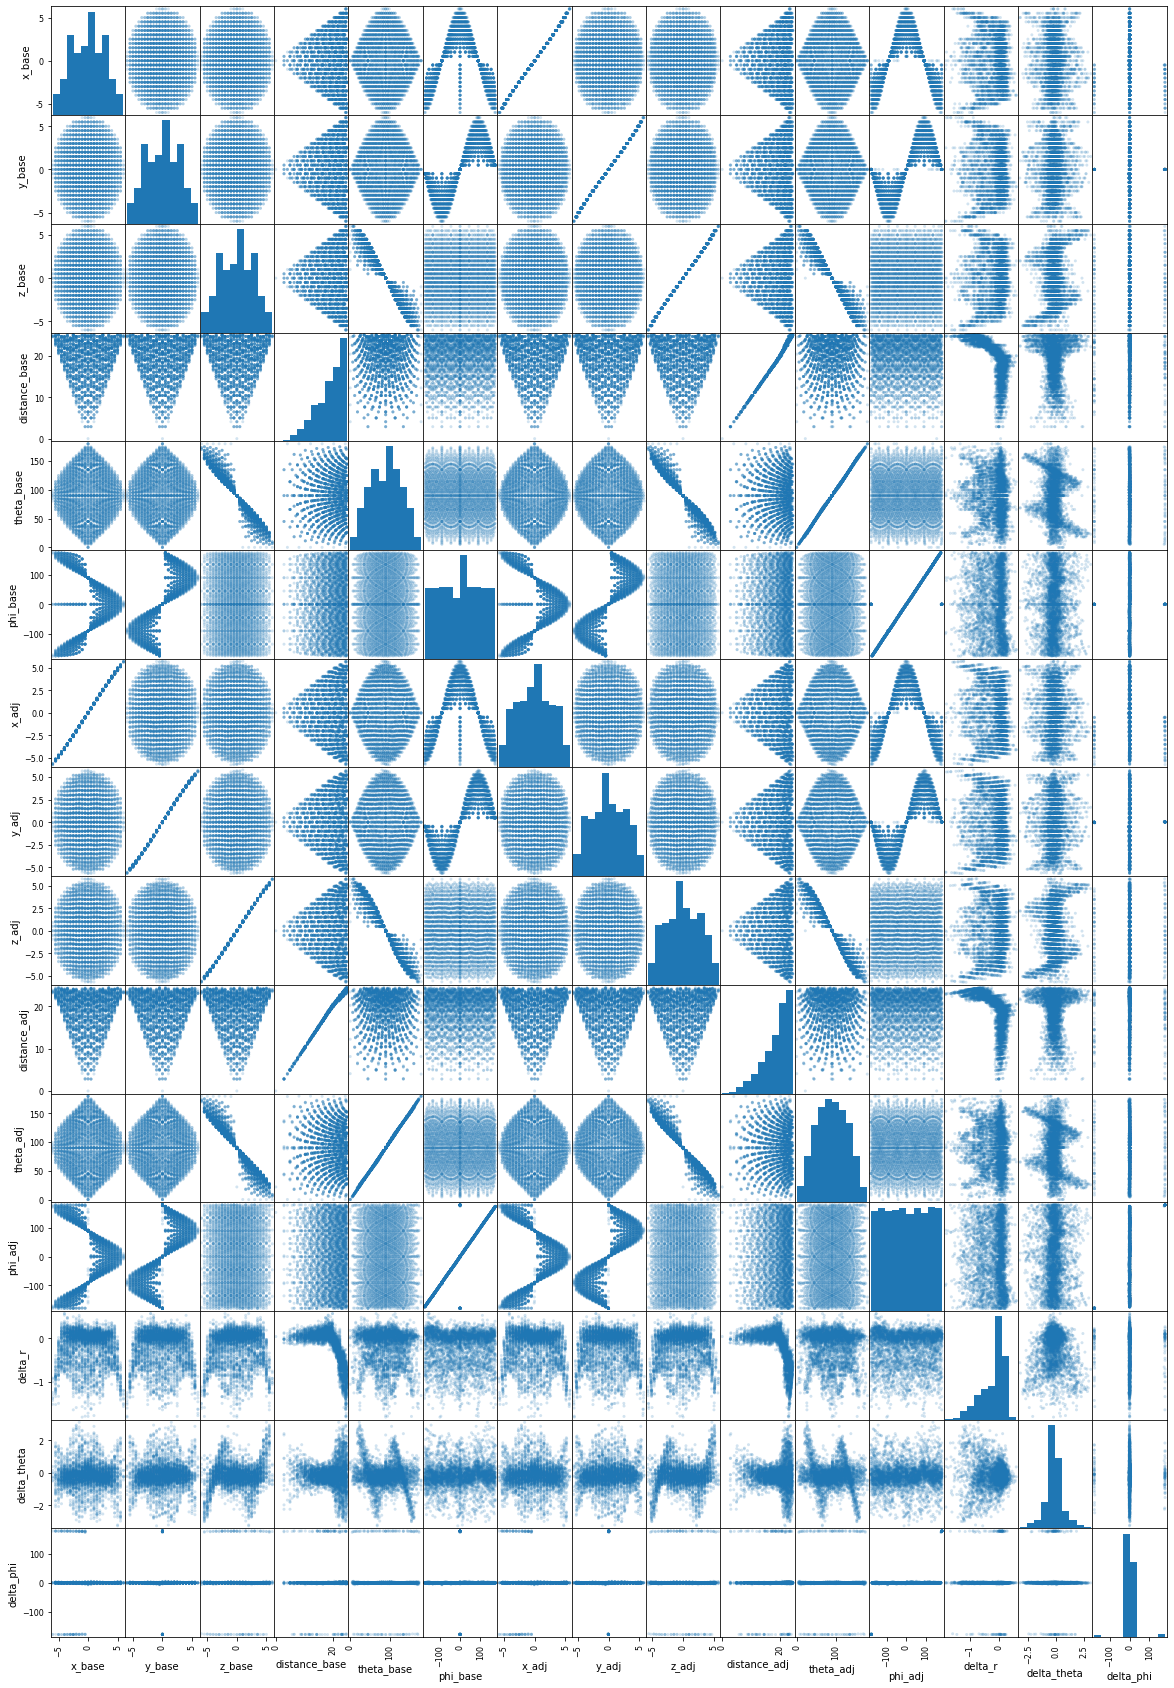

In [10]:
pd.plotting.scatter_matrix(data_total, alpha=.2, figsize=(20,30));

## Plots

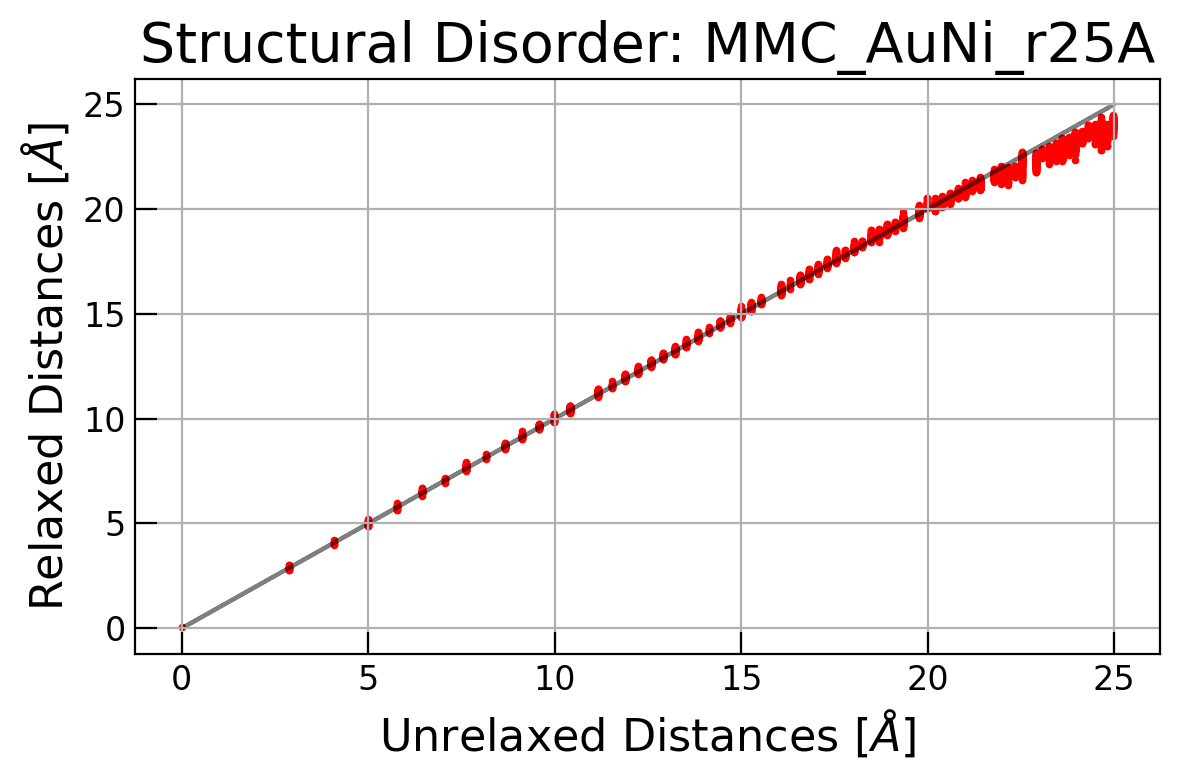

In [11]:
################################################################################
# Plot Data
################################################################################
fig, ax = plt.subplots(figsize=(6,4),dpi=200)
ax.plot(data_total.distance_base,data_total.distance_base, color='black', zorder=1, alpha=.5)
ax.scatter(data_total.distance_base, data_total.distance_adj, color='red', s=3, zorder=0)
################################################################################
# Plot settings
################################################################################
ax.set_title(plotTitle, fontsize=20)
ax.set_ylabel(r'Relaxed Distances [$\AA$]', fontsize=16)
ax.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax.set_xlabel(r'Unrelaxed Distances [$\AA$]', fontsize=16)
ax.tick_params(axis='x', labelsize=12, direction='in', length=8)
#ax.set_xlim(0,10)
#ax.set_ylim(0,10)
#ax.legend()
ax.grid(True)
plt.tight_layout()
# Uncomment to save and download plots
plt.savefig(plotsavename1)
files.download(plotsavename1)

In [12]:
data_byNN1 = data_total.groupby("distance_base")["distance_adj"].mean()
data_byNN2 = data_total.groupby("distance_base")["distance_adj"].std()
data_byNN2 = data_byNN2.fillna(0)

In [13]:
data_byNN_total = pd.concat([data_byNN1, data_byNN2], axis=1)
data_byNN_total.columns = ["mean", "std"]
data_byNN_total["distance_base"] = data_byNN_total.index
print(len(data_byNN_total["distance_base"]))
print(len(data_byNN_total["mean"]))
data_byNN_total

92
92


mean       std  distance_base
distance_base                                    
0.000000        0.042319  0.000000       0.000000
2.884218        2.876764  0.069885       2.884218
4.078900        4.071237  0.080160       4.078900
4.995612        5.010438  0.087001       4.995612
5.768436        5.787524  0.096463       5.768436
...                  ...       ...            ...
24.473400      23.804069  0.137246      24.473400
24.642768      23.704710  0.332637      24.642768
24.810980      23.486088  0.292397      24.810980
24.978059      24.090280  0.148728      24.978059
24.978059      24.054070  0.226248      24.978059

[92 rows x 3 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

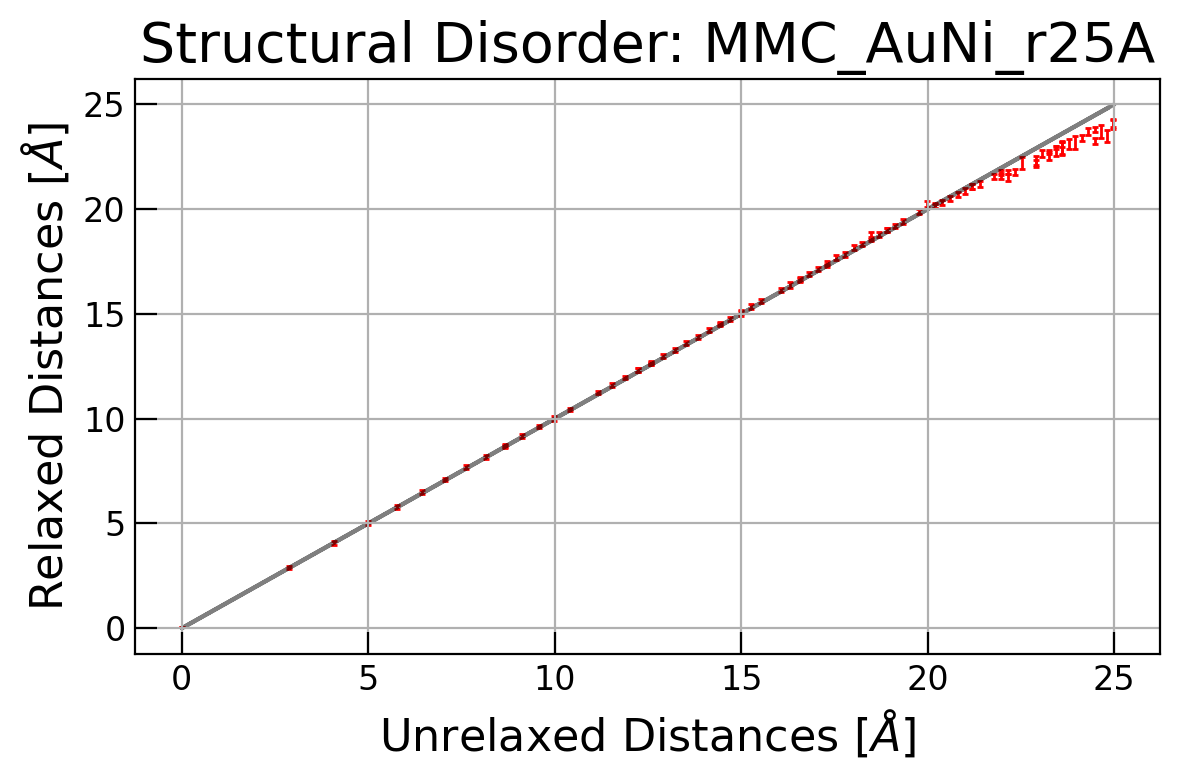

In [14]:
################################################################################
# Plot Data
################################################################################
fig, ax = plt.subplots(figsize=(6,4),dpi=200)
ax.plot(data_total.distance_base,data_total.distance_base, color='black', zorder=1, alpha=.5)
ax.errorbar(data_byNN_total["distance_base"], data_byNN_total["mean"], yerr=data_byNN_total["std"], color='red', fmt=' ', zorder=0, capsize=1, elinewidth=1,
   markeredgewidth=1)
################################################################################
# Plot settings
################################################################################
ax.set_title(plotTitle, fontsize=20)
ax.set_ylabel(r'Relaxed Distances [$\AA$]', fontsize=16)
ax.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax.set_xlabel(r'Unrelaxed Distances [$\AA$]', fontsize=16)
ax.tick_params(axis='x', labelsize=12, direction='in', length=8)
#ax.set_xlim(0,10)
#ax.set_ylim(0,10)
#ax.legend()
ax.grid(True)
plt.tight_layout()
# Uncomment to save and download plots
plt.savefig(plotsavename2)
files.download(plotsavename2)

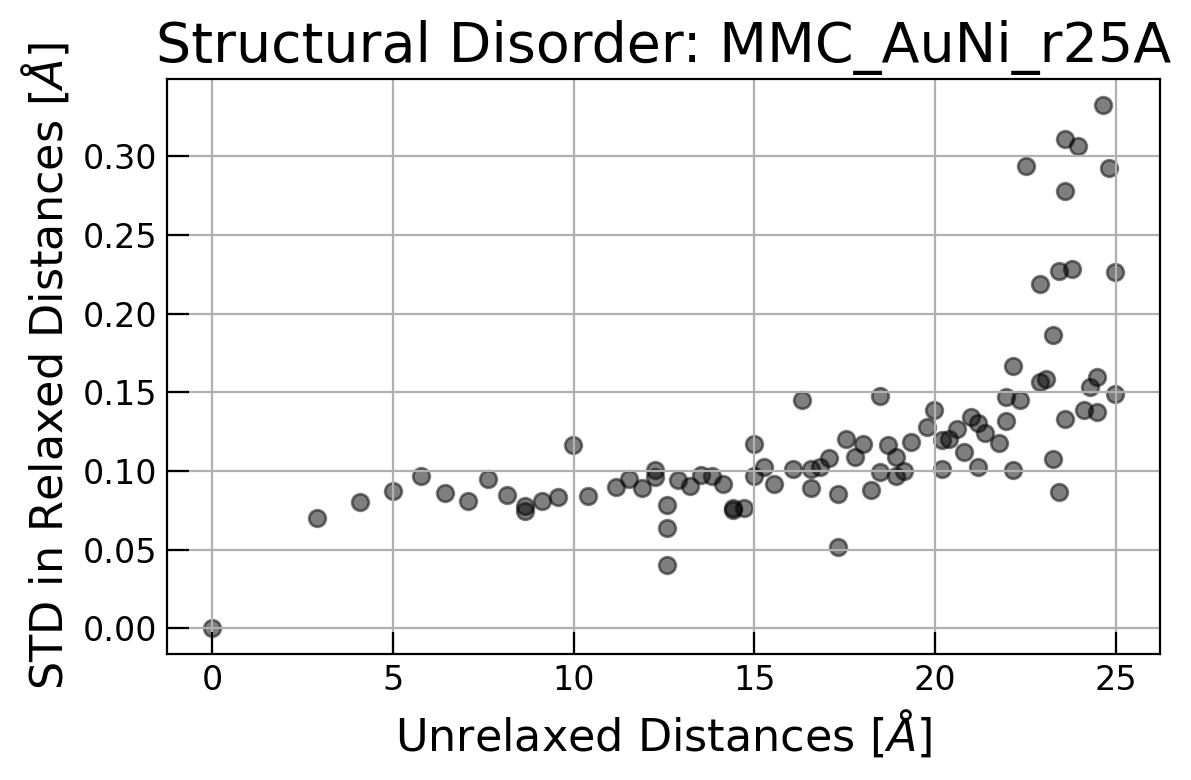

In [15]:
################################################################################
# Plot Data
################################################################################
fig, ax = plt.subplots(figsize=(6,4),dpi=200)
ax.scatter(data_byNN_total["distance_base"],data_byNN_total["std"], color='black', zorder=1, alpha=.5)
################################################################################
# Plot settings
################################################################################
ax.set_title(plotTitle, fontsize=20)
ax.set_ylabel(r'STD in Relaxed Distances [$\AA$]', fontsize=16)
ax.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax.set_xlabel(r'Unrelaxed Distances [$\AA$]', fontsize=16)
ax.tick_params(axis='x', labelsize=12, direction='in', length=8)
#ax.set_xlim(0,10)
#ax.set_ylim(0,10)
#ax.legend()
ax.grid(True)
plt.tight_layout()
# Uncomment to save and download plots
plt.savefig(plotsavename3)
files.download(plotsavename3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

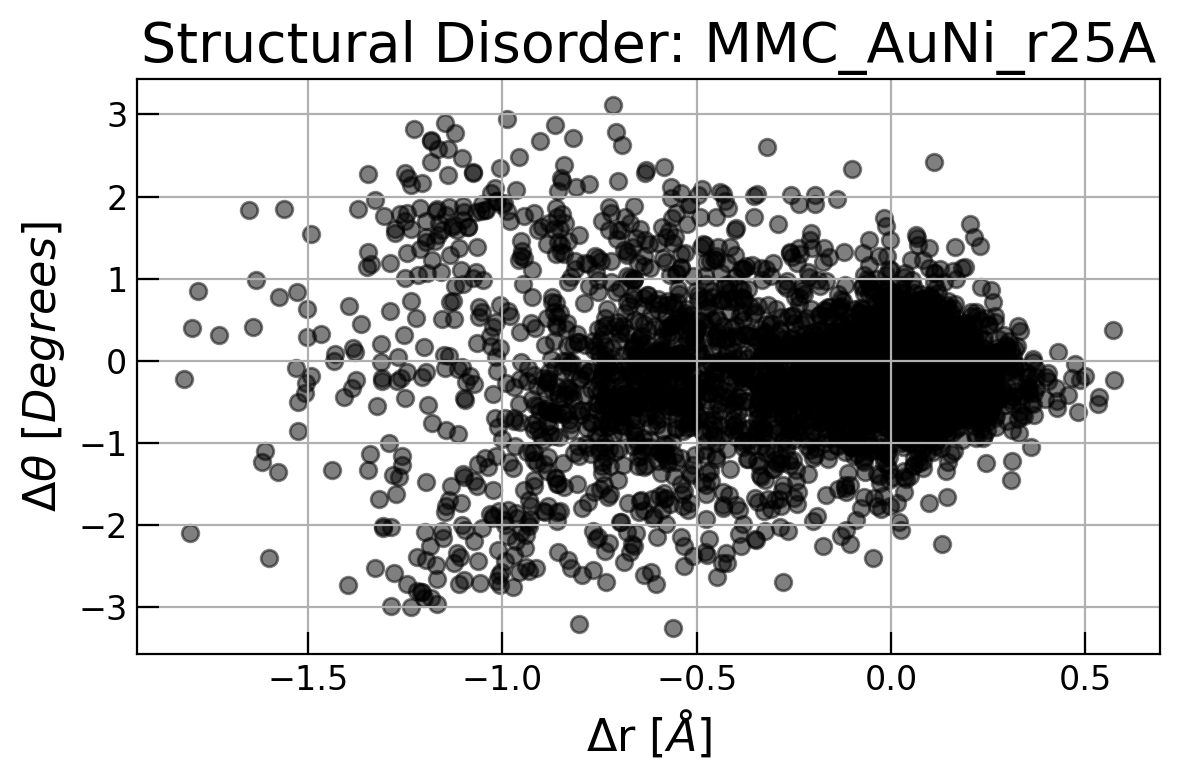

In [20]:
################################################################################
# Plot Data
################################################################################
fig, ax = plt.subplots(figsize=(6,4),dpi=200)
ax.scatter(data_total["delta_r"], data_total["delta_theta"], color='black', zorder=1, alpha=.5)
################################################################################
# Plot settings
################################################################################
ax.set_title(plotTitle, fontsize=20)
ax.set_ylabel(r'$\Delta\theta$ [$Degrees$]', fontsize=16)
ax.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax.set_xlabel(r'$\Delta$r [$\AA$]', fontsize=16)
ax.tick_params(axis='x', labelsize=12, direction='in', length=8)
#ax.set_xlim(0,10)
#ax.set_ylim(0,10)
#ax.legend()
ax.grid(True)
plt.tight_layout()
# Uncomment to save and download plots
plt.savefig(plotsavename4)
files.download(plotsavename4)